# My MyAnimeList
In this project I will be exploring the world of the Japanese Animation (Anime) though the analysis of the catalog of [MyAnimeList](https://myanimelist.net/).\
MyAnimeList, or **MAL**, is a social cataloging application website which contains the most popular dataset of anime and includes user ratings and reviews, myselft included.

In what follows I will provide some insights into the database via a statistical analysis.\
Some of the questions I will try to answer are:
1. Are anime more popular in the streaming era than they were before?
2. Are anime just cartoons for kids?
3. What has been the best year for anime so far?
4. What are the Studios that release the most popular anime?
5. Is there a gender gap in anime i.e. Shounen vs. Shoujo and Seinen vs Josei?
6. Are original anime better received than manga/light-novel adaptation?

And lastly, this is _**MY**_ MyAnimeList therefore I will also present and analize my personal catalog of anime to that of other users on MAL.

## The Datasets
The datasets that will be taken under considerations are `animelist.csv` and `myanimelist.csv`.\
### myanimelist.csv
The first one contains the list of the shows that I have added to MAL.\
MAL gives the possibility to registered users to export their list as `.xml` file.\
To make this list more accessible it is good practice to convert it to `.csv`.\
The following code block will `import` the `xml.ElementTree` and `csv` libraries into Python, **read** the xml file with the `ET` parser, save it in a dictonary and then **write** the dictonary to a new file called `myanimelist.csv`.

In [1]:
import xml.etree.ElementTree as ET
import csv

# =============================================================================
#  Read in the xml file using the python parser
# =============================================================================

tree = ET.parse('animelist6.xml')
root = tree.getroot()

# populate my personal info. Still don't know what to do whit this
my_info = { 
    'user_id': int(root[0][0].text),
    'user_name': root[0][1].text,
    'total_anime': int(root[0][3].text),
    'watching': int(root[0][4].text),
    'completed': int(root[0][5].text),
    'on_hold': int(root[0][6].text),
    'dropped': int(root[0][7].text),
    'plan_to_watch': int(root[0][8].text)
    }

# Populate my anime list in a dictonary 
anime_dict = []
for i, child in enumerate(root, start=0):
    if child.tag == 'anime':
        anime_dict.append({
            'series_id': int(root[i][0].text),
            'series_title': root[i][1].text,
            'series_type': root[i][2].text,
            'series_episodes': int(root[i][3].text),
            'my_watched_episodes': int(root[i][5].text),
            'my_score': int(root[i][9].text),
            'my_status': root[i][12].text
            })

fields = []
for element in anime_dict[0].keys():
    fields.append(element)

# =============================================================================
# Write my anime list to a csv file
# =============================================================================
with open('myanimelist.csv', 'w+') as anime_csv:
        writer = csv.DictWriter(anime_csv, fieldnames=fields)
        writer.writeheader()
        
        for item in anime_dict:
            writer.writerow(item)


The file is now ready to be imported with Pandas

In [2]:
import pandas as pd

mal = pd.read_csv('myanimelist.csv');

This DataFrame has 7 columns and 179 rows.\
Rows represent anime\
The columns are:
* `series_id`: a type **integer** number that uniquely identifies the entry
* `series_title`: a **string** containg the name of the show
* `series_type`: a **string** describing the type of show e.g. Movie, TV, ONA
* `series_episodes`: a type **integer** number that reports the number of episodes
* `my_watched_episodes`: a type **integer** number with the counts the number of episodes I watched for that entry
* `my_score` : a type **integer** number from 1 to 10 indicating my degree of approval. 0 indicates "no vote"
* `my_status`: a **string** indicating the cuurent status of the show: _"Completed"_, _"Watching"_, _"On-Hold"_, _"Dropped"_, _"Plan to Watch"_

### anime.csv
The second file is available at this [link](https://www.kaggle.com/hernan4444/anime-recommendation-database-2020)
and contains general information about a large list of anime in MAL.
The file can be imported and inspected in Python with Pandas

In [3]:
anime = pd.read_csv('anime.csv');
print(anime.shape)  # print the dimension of the table (n. rows, n. columns)
pd.set_option('display.max_columns', None) # print all the columns
# print(anime.head()) # print the irst file rows of the DataFrame
print(anime.dtypes) # print the type of the data

(17562, 35)
MAL_ID            int64
Name             object
Score            object
Genders          object
English name     object
Japanese name    object
Type             object
Episodes         object
Aired            object
Premiered        object
Producers        object
Licensors        object
Studios          object
Source           object
Duration         object
Rating           object
Ranked           object
Popularity        int64
Members           int64
Favorites         int64
Watching          int64
Completed         int64
On-Hold           int64
Dropped           int64
Plan to Watch     int64
Score-10         object
Score-9          object
Score-8          object
Score-7          object
Score-6          object
Score-5          object
Score-4          object
Score-3          object
Score-2          object
Score-1          object
dtype: object


This table contains 17562 anime entries (rows) and 35 columns.\

From a quick inspection it is clear that some of the columns are not proprerly formatted.\
For example the columns `Episodes`,`Ranked` and `Score` are all identified as type `object` whereas they should be of type `integer`.\
In order to get the data in a form which is ready for analysis a process of data cleaning and manipulation must be performed.
## Database cleaning
The cleaning a datasets is often the most time-consuming and tedious part of a database analysis.
In this process I will adhere to the following scheme:
1. Make sure that the columns are named properly and that they follow the standard naming convention.
2. Drop unusable or duplicate columns.
3. Change data types where needed.
4. Handle missing or incorrect data.

### Column Naming
Good naming practise allows users to easily access the data within columns.
For example avoiding white spaces makes possible to use the dot notation to access the elements in the columns.\
In this amine DataFrame only 3 columns do not follow this convention: `English name`, `Japanese name` and `Plan to Watch`.\
I will also rename the column `Genders` to `Genres` as the former can can be easily misinterpreted.

In [4]:
anime = anime.rename(columns={"English name": "English_name",
                      "Japanese name": "Japanese_name", 
                      "Genders": "Genres",
                      "Plan to Watch": "Plan_to_Watch"})

### Drop columns
To keep the database more organized it is a good idea to drop the columns that are either repetitive or are of no use for the analysis.\
Initially only 4 columns (`Japanese_name`, `Aired`, `Licensors`, `Producers`) will be discarded from the datasets as they contain repetitive or non usable information for this analysis.
At the end of the cleaning prcess more columns can be removed as well.

In [5]:
anime = anime.drop(columns=['Japanese_name', 'Aired', 'Licensors', 'Producers']) # Drop columns by name

### Changing data type
Changng data type is the core of the data **cleaning process**.\
It's paramount to make sure that the data included in the columns is associated to the **correct type**.\
If a column that contains numbers is reported as type `object` type it will be not possible to perfom mathematical operations with its entries.\
It is also important to identify **missing** or **incorrect** information in the datasets.\
Inspection of the data types shows that the columns `Score`, `Episodes`, `Premiered`, `Duration`, `Ranked`, `Score-1, ... ,Score-10` are all of type `object` while they should be numerical (`integer` or `float`) type.
#### Score
It lists a **weighted average score** of the associated show.\
The mathematical equation to calculate this score is not relevant to this analysis and morover can be subject to change over time.\
What it must be pointed out are 3 elements:
1. The correct **dtype** for this column should thus be `float`
2. This will be different for the **arithmetic mean**
3. The Score cannot be a **negative** number

Inspection of the unique values in the column shows that missing scores are reported as `Unknown`.\
The code block below will identify how many rows have an `Unknown` score.\
It will change its value to zero (`0`) and convert the type to `float`.

In [6]:
import numpy as np

# print(anime['Score'].unique()); # print unique entries in the column
print(len(anime[anime['Score'] == 'Unknown'])) # Print the number of "Unknown" occurrance in the column
anime['Score'] = anime['Score'].mask(anime['Score'] == 'Unknown', 0) # Replace "Unknown" with 0
anime['Score'] = pd.to_numeric(anime['Score']) # Convert the type from string to numeric
# print(anime['Score'].unique())
print(anime['Score'].dtypes)

5141
float64


#### Episodes
Like Score, Episodes is listed as type `object`.\
This column should contain the number of episodes listed for the series thus `int` would be the correct data type instead.\
Inspecting the unique entries in this column we notice that there are 516 rows in which the number of episode is not reported and replaced with "Unknown".\
As previously done, we will clean this column and replace the unknown entries with 0

In [7]:
print(len(anime[anime['Episodes'] == 'Unknown'])) 
anime['Episodes'] = anime['Episodes'].mask(anime['Episodes'] == 'Unknown', 0)
anime['Episodes'] = pd.to_numeric(anime['Episodes'])
print(anime['Episodes'].dtypes)

516
int64


#### Premiered
This column reports the period of the year in which the series has been released (**'winter', 'spring', 'summer', 'fall'**) and the **year** as a single `string`.\
Like in the previous column, data not available is reported as `Unknown`.\
It is useful to split this column into two new distinct columns of different type.\
1. **season** of type `string`
2. **year**  of type `integer`

The code block below will split the column `Premiered` into two columns `Season` and `Year`.\
The resulting `Season` column will contain only 5 unique entries.\
The column `Year` will contain `None` entries where `anime['Premired'] == 'Unknown'`, thus before converting it to numerical type we must account for this.

In [8]:
premiered_split = anime['Premiered'].str.split(' ', expand=True) 
anime['Season'] = premiered_split[0]  # We leave this column as it is
anime['Year'] = premiered_split[1]
# print(anime.columns)

anime['Year'] = anime['Year'].mask(pd.isna(anime['Year']), 1868) # Remove None and replace with 1868
anime['Year'] = pd.to_numeric(anime['Year']) # convert to integer
print(anime.dtypes)


MAL_ID             int64
Name              object
Score            float64
Genres            object
English_name      object
Type              object
Episodes           int64
Premiered         object
Studios           object
Source            object
Duration          object
Rating            object
Ranked            object
Popularity         int64
Members            int64
Favorites          int64
Watching           int64
Completed          int64
On-Hold            int64
Dropped            int64
Plan_to_Watch      int64
Score-10          object
Score-9           object
Score-8           object
Score-7           object
Score-6           object
Score-5           object
Score-4           object
Score-3           object
Score-2           object
Score-1           object
Season            object
Year               int64
dtype: object


#### Duration
This column reprts the runtime of the show in the associated row.\
Ideally one would want to have this as numerical type to perfom mathematical operations with its entries.\
In the dataset `Duration` is expressed in string-like form such as: `1 hr. 45 min.`, `52 min.`, `1 hr. 59 min.`, `2 hr.`\
The block code bolow performs string manipulation and data convertion to properly display the runtime in minutes.\
Shows of `Unknown` duration (?) will have a runtime of zero (`0`).\
A more elegant and possibly faster solution can be achieved with `regex` or using the datetime manipulation library `Arrow`


In [9]:
# Duration
duration = anime['Duration']
duration = duration.str.split(' ', expand=True)

for i in range(len(duration)):
    if duration[1][i] == 'min.':
        # print(duration[1][i])
        duration[4][i] = int(duration[0][i]) * 60
    elif duration[1][i] == 'hr.':
        # print(duration[1][i])
        duration[4][i] = int(duration[0][i]) * (60 ** 2)
    elif duration[1][i] == 'sec.':
        duration[4][i] = int(duration[0][i])
        # print(duration[1][i])
    else:
        # print(duration[1][i])
        duration[4][i] = 0
    
    if duration[2][i] is None:
        continue
    else:
        try:
            duration[4][i] +=  int(duration[2][i]) * 60
        except ValueError:
            pass

anime['Duration'] = pd.to_numeric(duration[4] / 60)

#### Ranked
This column _probably_ lists the number of interacton for a show. i.e. how many time a show has been ranked.\
Data convertion in this case it's very simple:
* replace `Unknown` entries with zeros (`0`)
* convert to integer

In [10]:
anime['Ranked'] = anime['Ranked'].mask(anime['Ranked'] == 'Unknown', 0)
anime['Ranked'] = pd.to_numeric(anime['Ranked'])

#### Score-1 to Score-10
In this 10 columns are reported the count of the specified score received by the show.\
Like in the previous case all it has to be done is
* replace `Unknown` entries with zeros (`0`)
* convert to integer

This can be optimized with a function that runs in a loop: it's the same command executed 10 times

In [11]:
# Score-10
anime['Score-10'] = anime['Score-10'].mask(anime['Score-10'] == 'Unknown', 0)
anime['Score-10'] = pd.to_numeric(anime['Score-10'])

# Score-9
anime['Score-9'] = anime['Score-9'].mask(anime['Score-9'] == 'Unknown', 0)
anime['Score-9'] = pd.to_numeric(anime['Score-9'])

# Score-8
anime['Score-8'] = anime['Score-8'].mask(anime['Score-8'] == 'Unknown', 0)
anime['Score-8'] = pd.to_numeric(anime['Score-8'])

# Score-7
anime['Score-7'] = anime['Score-7'].mask(anime['Score-7'] == 'Unknown', 0)
anime['Score-7'] = pd.to_numeric(anime['Score-7'])

# Score-6
anime['Score-6'] = anime['Score-6'].mask(anime['Score-6'] == 'Unknown', 0)
anime['Score-6'] = pd.to_numeric(anime['Score-6'])

# Score-5
anime['Score-5'] = anime['Score-5'].mask(anime['Score-5'] == 'Unknown', 0)
anime['Score-5'] = pd.to_numeric(anime['Score-5'])

# Score-4
anime['Score-4'] = anime['Score-4'].mask(anime['Score-4'] == 'Unknown', 0)
anime['Score-4'] = pd.to_numeric(anime['Score-4'])

# Score-3
anime['Score-3'] = anime['Score-3'].mask(anime['Score-3'] == 'Unknown', 0)
anime['Score-3'] = pd.to_numeric(anime['Score-3'])

# Score-2
anime['Score-2'] = anime['Score-2'].mask(anime['Score-2'] == 'Unknown', 0)
anime['Score-2'] = pd.to_numeric(anime['Score-2'])

# Score-1
anime['Score-1'] = anime['Score-1'].mask(anime['Score-1'] == 'Unknown', 0)
anime['Score-1'] = pd.to_numeric(anime['Score-1'])

In [12]:
print(anime.dtypes)

MAL_ID             int64
Name              object
Score            float64
Genres            object
English_name      object
Type              object
Episodes           int64
Premiered         object
Studios           object
Source            object
Duration         float64
Rating            object
Ranked           float64
Popularity         int64
Members            int64
Favorites          int64
Watching           int64
Completed          int64
On-Hold            int64
Dropped            int64
Plan_to_Watch      int64
Score-10         float64
Score-9          float64
Score-8          float64
Score-7          float64
Score-6          float64
Score-5          float64
Score-4          float64
Score-3          float64
Score-2          float64
Score-1          float64
Season            object
Year               int64
dtype: object


## Statistical analysis
### Descriptive statistics
The first part of this statistical analysis revolves around the collection and the interpretation of few  statistical parameters evaluated for some representative columns of the dataset that will tell where the data is centered and how it is spread.\
The analysis will be supported by the use of hstograms, berplots, boxplots and pieplots.\
* Identify and describes the variable types in the database
* List some of the analysis that can be performed to the columns
* How we present the resuts ( which type of plots)
### Mean, Median, Mode


The mean Score, accounted for anime with zero score, is 6.51
The median Score, accounted for anime with zero score, is 6.52
The mode Score, accounted for anime with zero score, is 6.48 and its frequency is 74


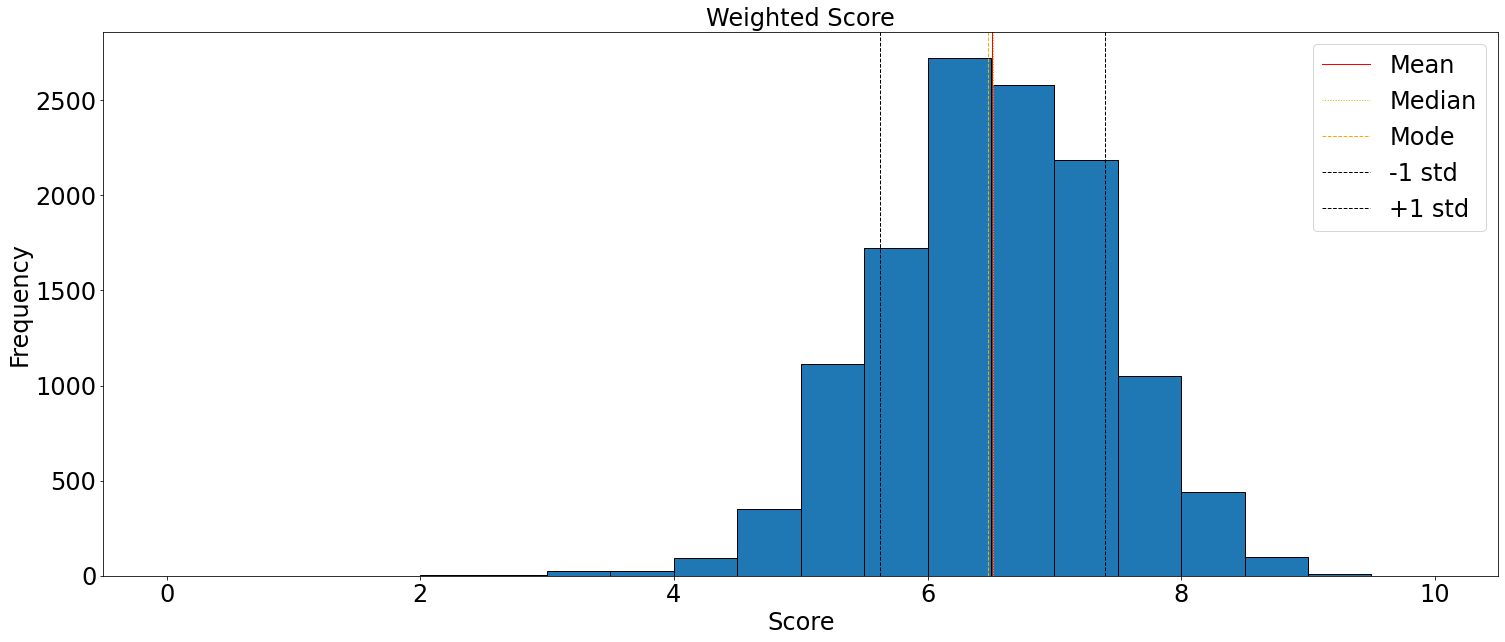

The mean Duration, accounted for anime with unknown duration, is 26.52
The median Duration, accounted for anime with unknown duration, is 24.0
The mode Duration, accounted for anime with unknown duration, is 24.0 and its frequency is 1892


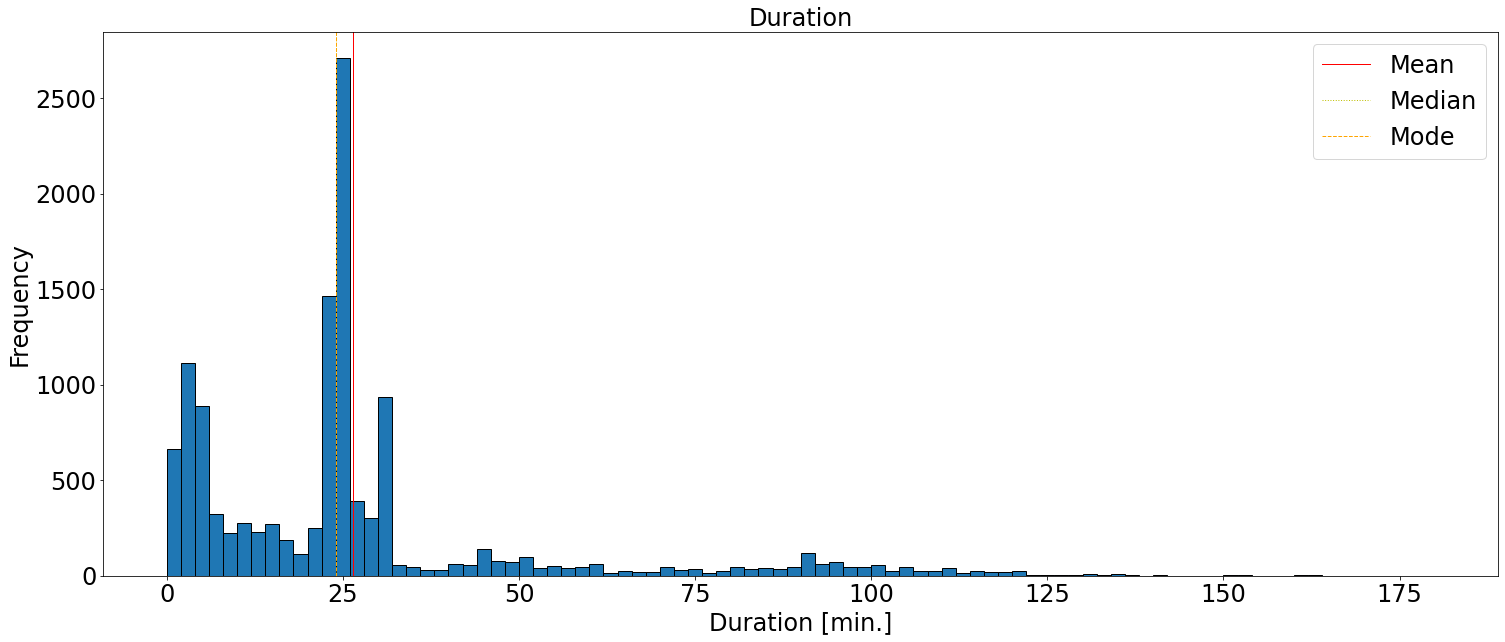

In [13]:
from scipy import stats
from matplotlib import pyplot as plt

score = anime[anime['Score'] > 0]
# Mean
mean_score = np.mean(score['Score'])
print('The mean Score, accounted for anime with zero score, is', round(mean_score, 2))
# Median
median_score = np.median(score['Score'])
print('The median Score, accounted for anime with zero score, is', round(median_score, 2))
# Mode
mode_score = stats.mode(score['Score'])
print('The mode Score, accounted for anime with zero score, is', round(mode_score[0][0], 2),
      'and its frequency is', mode_score[1][0])

# print(anime['Name'][anime['Score'] == np.min(score['Score'])]) # print anime with lowest aggregate score
# print(anime['Name'][anime['Score'] == np.max(score['Score'])]) # print anime with highest aggregate score

std_score = np.std(score['Score'])
iqr_score = stats.iqr(score['Score'])

# Score Histogram
fig, ax = plt.subplots(figsize=(25, 10))
plt.hist(score['Score'],
         range=(0, 10),
         bins=20,
         edgecolor='black')
plt.title("Weighted Score", fontsize=24)
plt.xlabel("Score", fontsize=24)
plt.ylabel("Frequency", fontsize=24)
plt.axvline(mean_score, color='r', linestyle='solid', linewidth=1, label="Mean")
plt.axvline(median_score, color='y', linestyle='dotted', linewidth=1, label="Median")
plt.axvline(mode_score[0][0], color='orange', linestyle='dashed', linewidth=1, label="Mode")
plt.axvline(mean_score - std_score, color='k', linestyle='dashed', linewidth=1, label="-1 std")
plt.axvline(mean_score + std_score, color='k', linestyle='dashed', linewidth=1, label="+1 std")
plt.legend(fontsize=24)
ax.tick_params(labelsize=24)
plt.show()
plt.close()

# Duration Histogram
duration = anime[anime['Duration'] > 0]
mean_duration = np.mean(score['Duration'])
print('The mean Duration, accounted for anime with unknown duration, is', round(mean_duration, 2))
median_duration = np.median(score['Duration'])
print('The median Duration, accounted for anime with unknown duration, is', round(median_duration, 2))
mode_duration = stats.mode(score['Duration'])
print('The mode Duration, accounted for anime with unknown duration, is', round(mode_duration[0][0], 2),
      'and its frequency is', mode_duration[1][0])

fig, ax = plt.subplots(figsize=(25, 10))
plt.hist(score['Duration'],
         range=(0, 180),
         bins=90, 
         edgecolor='black')
plt.title("Duration", fontsize=24)
plt.xlabel("Duration [min.]", fontsize=24)
plt.ylabel("Frequency", fontsize=24)
plt.axvline(mean_duration, color='r', linestyle='solid', linewidth=1, label="Mean")
plt.axvline(median_duration, color='y', linestyle='dotted', linewidth=1, label="Median")
plt.axvline(mode_duration[0][0], color='orange', linestyle='dashed', linewidth=1, label="Mode")
plt.legend(fontsize=24)
ax.tick_params(labelsize=24)
plt.show()


#### DIscussion
The first histogram displays the distribution of the **weighted user score** for all the anime in the dataset that have received a vaid numerical score (**12421**).\
The valid scores are in the range **1-10**. Choosing **20 bins** as a criteria to group the data will result in the score being represented with a step of **0.5** which will be an appropriate choice.\
As expected this histogram shows a normal distribuition with the average and the median weighted score equal **6.51**, and **6.52** respectively.
The mode Score is **6.48** and its frequency is **74**.
The fact that mean and median are close enforces the unimodal distribuition of this data.\
Visual appearence of this data shows little to no skewness.\
The show with the lowest weighted score is [**Tenkuu Danzai Skelter+Heaven**](https://myanimelist.net/anime/3287/Tenkuu_Danzai_Skelter_Heaven) with a value of **1.85** while the highest weighted score (**9.18**) is  [**Fullmetal Alchemist: Brotherhood**](https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood).\
The standard deviation (`std`) is **0.88** which is an indiation of little variation in the dataset. i.e. most of the data tends to be very close to the mean value.\
The interquartile range (`iqr`), which contains values larger than the 25th percentile and lower than the 75th percentile, has a width of **1.21**. This means that more than 50% of the data falls between within less than 1.5 std from the mean.\
Is this a suprising result? It's hard to say. Before drawing any conclusion out of this data it's important to look to the shows that have received very high and very low scores. 

The second histograms show the distribution of the runtime for all the anime in the dataset.\
Little can be said based on the visual appearence of this graph: The data is neither unimodal, nor bimodal.\
All the different types of shows (TV, Movie, ONA, OVA, Short) have in general very different duration and tend to cluster in different groups thus creating this apparent right-skewness in the distribution.\
For this reason, reporting quantities like mean and median for the whole dataset is not very informative of the data.\
It can be easily seen that both these parameters are centered around 25 minutes. Since the large majority of anime are TV Shows of variable length between 18 and 25 minutes it's not surprising that mean and meadian fall in this range.
A large catalog of short anime series and movies, with duration lower than 10 minutes, is also present in this dataset.\
It would make more sense to group first this anime for category and then repeat the analysis done for the score.\
The code block below will make a histogram for the **Movies**, **TV shows**, **ONA** and **OVA** and calculate few statistical quantities.


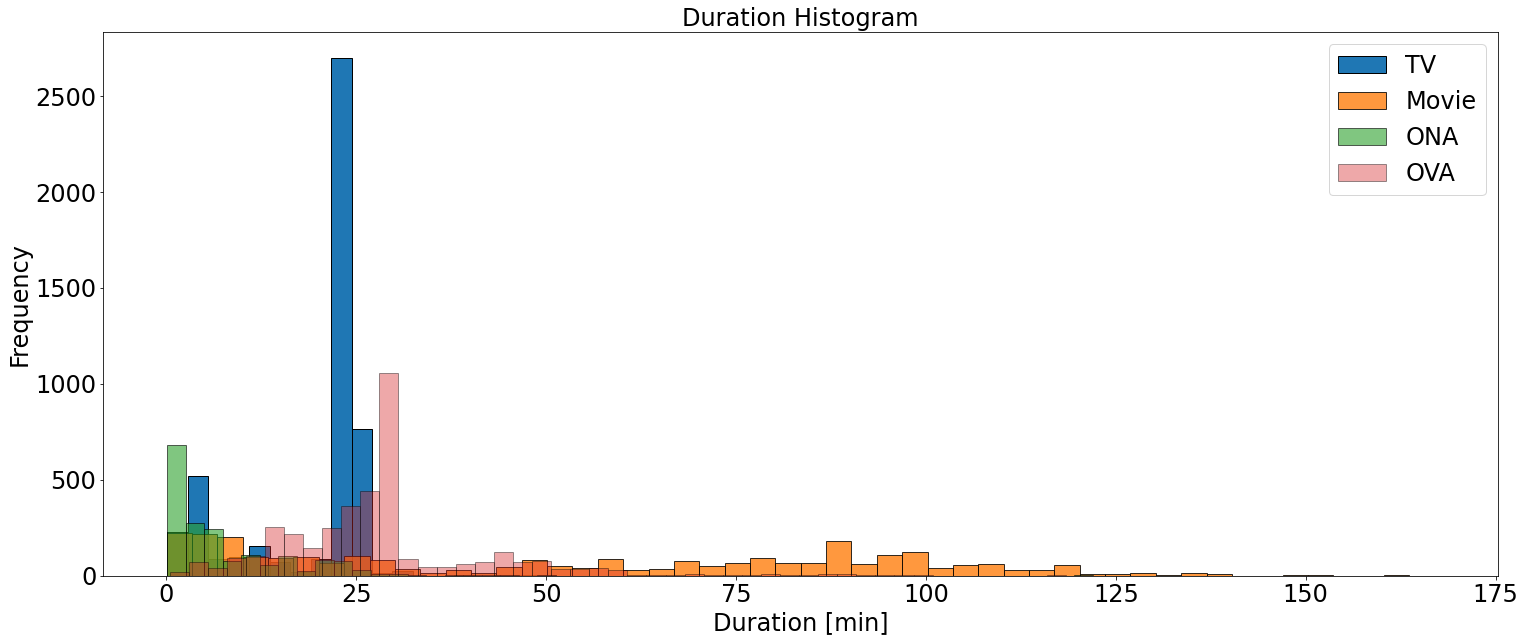

39.58928073934876



In [14]:
tv = anime[(anime['Type'] == 'TV') & (anime['Duration'] > 0)]
movie = anime[(anime['Type'] == 'Movie') & (anime['Duration'] > 0)]
ona = anime[(anime['Type'] == 'ONA') & (anime['Duration'] > 0)]
ova = anime[(anime['Type'] == 'OVA') & (anime['Duration'] > 0)]
# print(anime['Type'].unique())
# print(len(duration_tv))
# print(len(duration_movie))
# print(len(duration_ona))
# print(len(duration_ova))

fig, ax = plt.subplots(figsize=(25,10))
plt.hist(tv['Duration'], label="TV", bins=20, edgecolor='k')
plt.hist(movie['Duration'], alpha =.8, label='Movie', bins=50, edgecolor='k')
plt.hist(ona['Duration'], alpha =.6, label='ONA', bins=50, edgecolor='k')
plt.hist(ova['Duration'], alpha =.4, label="OVA", bins=50, edgecolor='k')
plt.xlabel("Duration [min]", fontsize=24)
plt.ylabel("Frequency", fontsize=24)
plt.title("Duration Histogram", fontsize=24)
plt.legend()
plt.legend(fontsize=24)
ax.tick_params(labelsize=24)
plt.show()

ova_mode = stats.mode(ova['Duration'])
ona_mode = stats.mode(ona['Duration'])
tv_mode = stats.mode(tv['Duration'])
std_movie = np.std(movie['Duration'])
print(std_movie)
# pd.set_option("max_rows", None)
print()

The new histograms grouped by types show distinct features:
1. As expected 'TV' is the largest group with a count of **4794**
2. Out of 4794 TV shows **3261** (68%) have a duration between 23 and 25 minutes with a mode of **24** minutes and a frequency of **1591**.
3. Movies have a very large spread (**standard deviation = 39.59 minutes**) ranging from very short films [Katsudou Shashin](https://myanimelist.net/anime/33187/Katsudou_Shashin) with a duration of just **3s** to [Tokyo Onlypic](https://myanimelist.net/anime/33533/Tokyo_Onlypic) with a runtime of **2 hours and 47 minutes**.
4. OVA is surprisingly the second largest group with a count of **3864** while 'Movie' is the third with **2886**
5. ONAs have a mode of **1** with a frequency of **276** such as e.g. [Ichiban Chikakute Tooi Hoshi](https://myanimelist.net/anime/48177/Ichiban_Chikakute_Tooi_Hoshi)
6. OVAs have a large spread with a mode of **30** minutes and a frequency of **924** among which [Dragon Ball Z: Atsumare! Gokuu World](https://myanimelist.net/anime/6714/Dragon_Ball_Z__Atsumare_Gokuu_World) and [Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen](https://myanimelist.net/anime/44/Rurouni_Kenshin__Meiji_Kenkaku_Romantan_-_Tsuioku-hen)

The top ten anime ranked by their highest weighted Score are listed below

In [15]:
# PRINT TOP 10
top10_tv =tv[tv['Score'] > 0].sort_values(by='Score', ascending=False)
print("TOP 10 Anime TV SHOWS:")
print(top10_tv['Name'].head(10).reset_index())
top10_movie = movie[movie['Score'] > 0].sort_values(by='Score', ascending=False)
print("\nTOP 10 Anime MOVIES:")
print(top10_movie['Name'].head(10).reset_index())
top10_ona = ona[ona['Score'] > 0].sort_values(by='Score', ascending=False)
print("\nTOP 10 Anime ONA:")
print(top10_ona['Name'].head(10).reset_index())
top10_ova = ova[ova['Score'] > 0].sort_values(by='Score', ascending=False)
print("\nTOP 10 Anime OVA:")
print(top10_ova['Name'].head(10).reset_index())

TOP 10 Anime TV SHOWS:
   index                                  Name
0   3971      Fullmetal Alchemist: Brotherhood
1  15926  Shingeki no Kyojin: The Final Season
2   5683                           Steins;Gate
3   6474                Hunter x Hunter (2011)
4   9913                              Gintama°
5  14963    Shingeki no Kyojin Season 3 Part 2
6   6006                              Gintama'
7   7261                   Gintama': Enchousen
8  12898            3-gatsu no Lion 2nd Season
9  12242                              Gintama.

TOP 10 Anime MOVIES:
   index                                               Name
0   9886                                     Koe no Katachi
1   7249  Gintama Movie 2: Kanketsu-hen - Yorozuya yo Ei...
2  11308                                     Kimi no Na wa.
3  15631                                 Gintama: The Final
4    176                      Sen to Chihiro no Kamikakushi
5  11103                   Kizumonogatari III: Reiketsu-hen
6  11684  Fate/sta

#### Boxplot

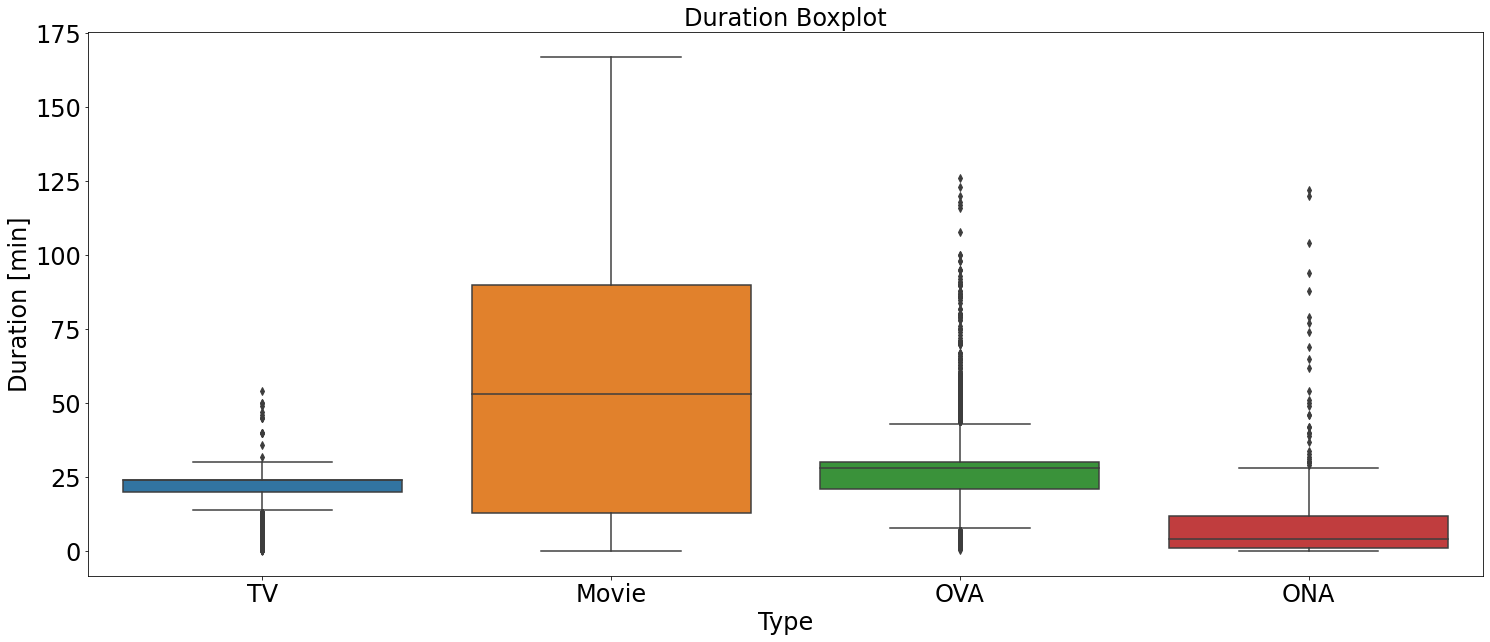

In [16]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.boxplot(data=anime[anime['Duration'] > 0],
            x='Type',
            y="Duration",
            order=["TV", "Movie", "OVA", "ONA"])
plt.xlabel("Type", fontsize=24)
plt.ylabel("Duration [min]", fontsize=24)
plt.title("Duration Boxplot", fontsize=24)
# plt.legend()
# plt.legend(fontsize=24)
ax.tick_params(labelsize=24)
plt.show()
plt.close()

## Is Anime getting more popular?
In order to answer this question it's important to define two aspects: _Popularity_ and _temporality_.\
As for the popularity we can use the "Popularity" column in our database.\
Popularity ranks the shows based on the number of MyAnimeList users that have them in their list.\
Temporality is a parameter used to dived the database in the pre-streming era and the streaming-era.\
This parameter is not clearly defined. Through the years in fact there has been a constant increase of streaming patforms that have included anime as product for their customers, thus making anime available for a larger audience especially in the west.\
In 2013 a new company, [**Crunchyroll**](https://beta.crunchyroll.com/), enter the competition.\
Crunchyroll is specifically focused on anime streaming and it can be credited for introducing the simulcast system which allows viewers from anywhere in the world to watch anime at the same time as theire rlease in Japan
For this reason anme before 2013 will be considered pre-streaming and post-2013 will be streaming era.


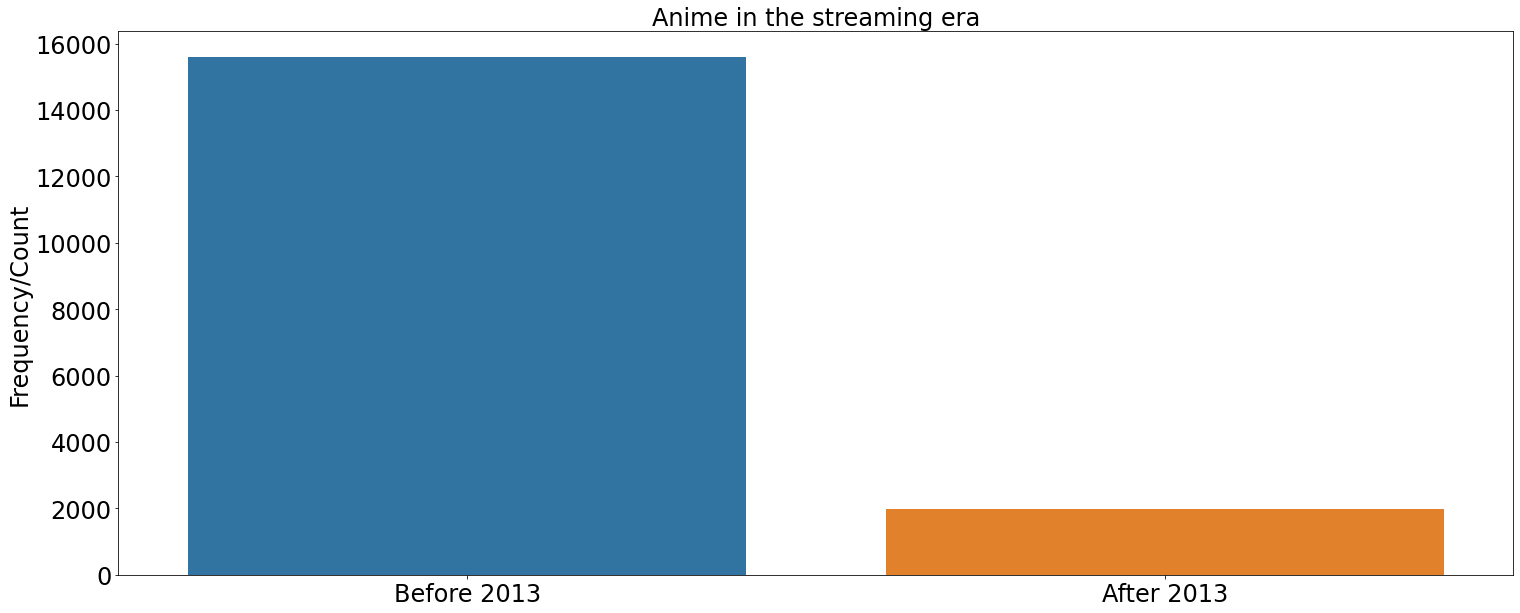

In [17]:
# Bar plot
anime['Streaming_era'] = anime['Year'].apply(lambda year: 'no' if year < 2013 else 'yes' )
fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.countplot(x="Streaming_era",
                   data=anime,
                   order=['no', 'yes'])
# plt.xlabel("Before 2013", fontsize=24)
plt.ylabel("Frequency/Count", fontsize=24)
plt.title("Anime in the streaming era", fontsize=24)
ax.set_xticks([0,1])
ax.set_xticklabels(['Before 2013', 'After 2013'])
ax.set_xlabel(None)
ax.tick_params(labelsize=24)
plt.show()
plt.close()

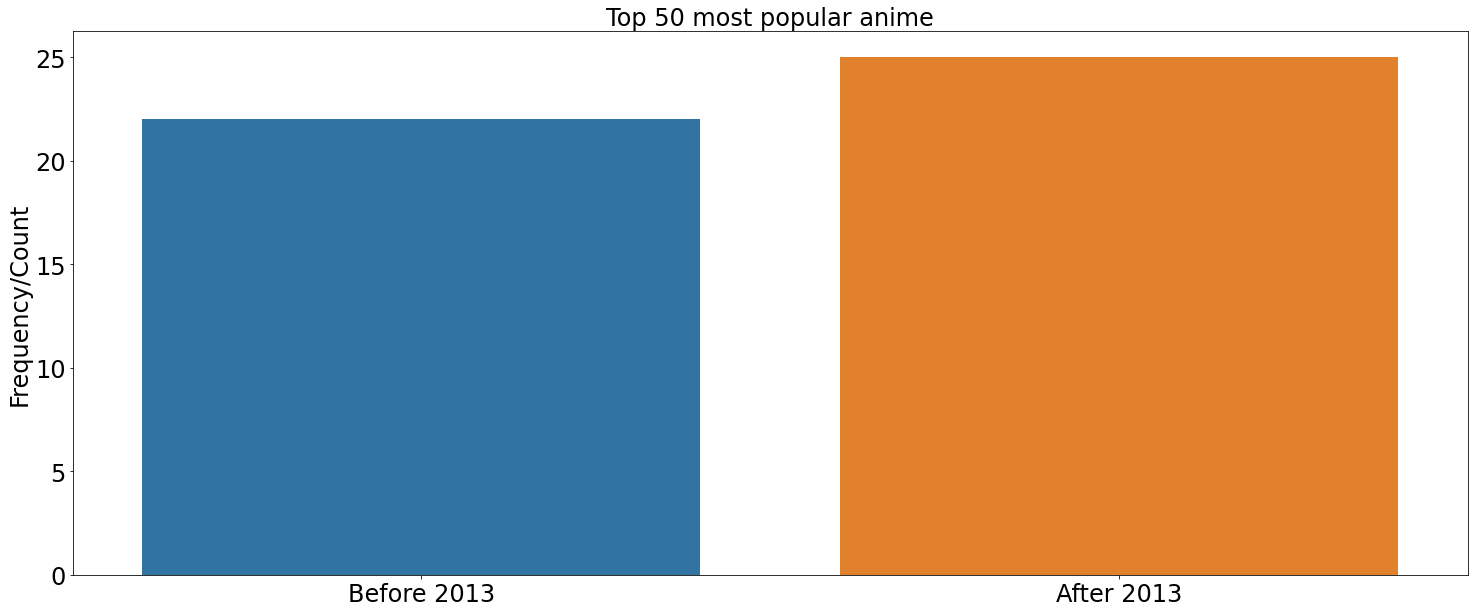

22


In [18]:
fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.countplot(x="Streaming_era",
                   data=anime[(anime['Popularity'] < 51) & (anime['Year'] > 1868)],
                   order=['no', 'yes'])
plt.xlabel("Before 2013", fontsize=24)
plt.ylabel("Frequency/Count", fontsize=24)
plt.title("Top 50 most popular anime", fontsize=24)
ax.set_xticks([0,1])
ax.set_xticklabels(['Before 2013', 'After 2013'])
ax.set_xlabel(None)
ax.tick_params(labelsize=24)
plt.show()
plt.close()
print(len(anime['Name'][(anime['Popularity'] < 51) & (anime['Year'] > 1868) & (anime['Year'] < 2013)].reset_index()))

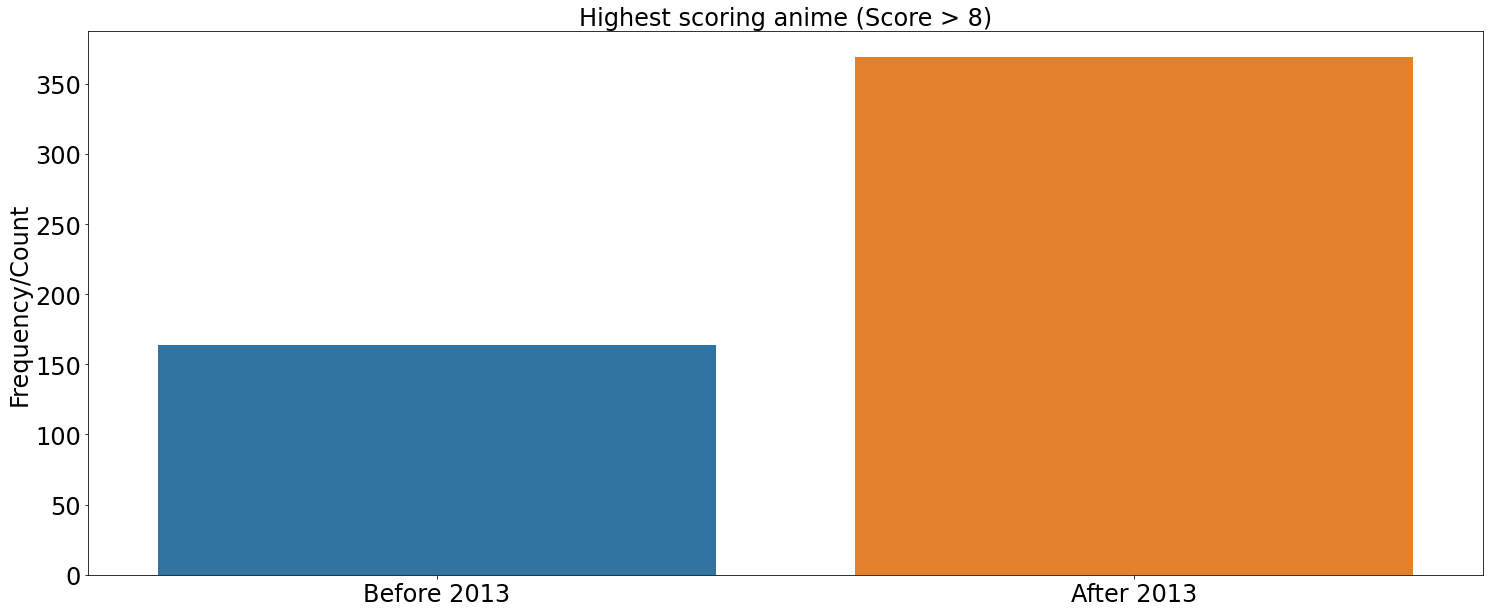

In [19]:
fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.countplot(x="Streaming_era",
                   data=anime[anime['Score'] > 8],
                   order=['yes', 'no'])
plt.xlabel("Before 2013", fontsize=24)
plt.ylabel("Frequency/Count", fontsize=24)
plt.title("Highest scoring anime (Score > 8)", fontsize=24)
ax.set_xticks([0,1])
ax.set_xticklabels(['Before 2013', 'After 2013'])
ax.set_xlabel(None)
ax.tick_params(labelsize=24)
plt.show()
plt.close()

### Discussion
It appears clarly from the first plot that out of 17562, about 2000 (12.5% of all anime) was produced after 2013.\
Yet only 22 anime made before the year 2013 belong to the top 50 most popular anime as it is shown in the middle barplot.\
Just because an anime is popular does not mean it is good. It is therefore important to show how rated are the anime before and after the beginning of the streamng era.\
The third and final plot of this section, where only anime with a score larger than 8 are reported, confirms that more recent shows are better received by fans than the old ones.\
This bias is even more striking if that the highest rated anime produced before 2013 are less than a half of those produced after 2013 but their total number is 8 times larger.\
In the following section the top ten anime in the columns `Completed`, `Dropped`, and `Plan to Watch` are listed.\
The anime that has been watched the most in its entirety is [**Shingeki no Kyojin**](https://myanimelist.net/anime/16498/Shingeki_no_Kyojin?q=shinge&cat=anime), a show that is currently still ongoing. As for theremaining entries, only 3 have been produced befoe 2013: [**Death Note**](https://myanimelist.net/anime/1535/Death_Note), [**Full Metal Alchemist: Brotherhood**](https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood?q=full%20metal%20al&cat=anime) and [**Naruto**](https://myanimelist.net/anime/20/Naruto).\
In the to 10 `Dropped` anime there are mostly popular long running anime, with 100+ episodes, with the exception of **Death Note** and [**Kill la Kill**](https://myanimelist.net/anime/18679/Kill_la_Kill).
Lastly, in the `Plan to Watch` column only 1 anime, which has yet to be distribuited globally is reported.\
The anime is the blockbuster record holder as the highest grossing anime movie of all time [**Demon Slayer -Kimetsu no Yaiba- The Movie: Mugen Train**](https://myanimelist.net/anime/40456/Kimetsu_no_Yaiba_Movie__Mugen_Ressha-hen?q=kimet&cat=anime)
The oter 9 entries are of from anime produced before 2013. 

In [20]:
# print(anime.head(10))
# df.groupby(by="a", dropna=False).sum()
# print(anime.columns)
# print(anime['Dropped'].sort_values(ascending=False))
print(anime.groupby('Name')['Completed'].sum().sort_values(ascending=False).head(10))
print(anime.groupby('Name')['Dropped'].sum().sort_values(ascending=False).head(10))
print(anime.groupby('Name')['Plan_to_Watch'].sum().sort_values(ascending=False).head(10))
# print(anime.groupby('Dropped')['Name'].count().sort_values(ascending=False))

Name
Shingeki no Kyojin                  2182587
Death Note                          2146116
Sword Art Online                    1907261
One Punch Man                       1841220
Boku no Hero Academia               1655900
Fullmetal Alchemist: Brotherhood    1644938
Tokyo Ghoul                         1594880
Naruto                              1462223
Kimi no Na wa.                      1462143
No Game No Life                     1426896
Name: Completed, dtype: int64
Name
Bleach                             174710
Fairy Tail                         148408
One Piece                          136245
Naruto: Shippuuden                 124253
Boruto: Naruto Next Generations    113677
Naruto                              99806
Sword Art Online                    90661
Black Clover                        89594
Death Note                          80834
Kill la Kill                        67845
Name: Dropped, dtype: int64
Name
Steins;Gate                                 425531
Cowboy Bebop    

## Is anime just for kids?
A common misconception about anime is that it is just a _"cartoon"_, a term often used in the western world with the negative connotation of "product meant just for children".
Interesting enough, the graph above shows the count of all the anime in the datasets grouped by their rating system.\
Although a large portion of anime is intended for children of all age (columsn 2 and 3), it is worthy notice that products reserved exclusively to a mature audience (columns 4, 5, and 6) are much more than those reserved only for children of young age.\
It is also important to notice that several anime classic like [**Lupin the Third**](https://myanimelist.net/anime/1412/Lupin_III), [**Tiger Mask**](https://myanimelist.net/anime/3009/Tiger_Mask) and [**Saint Seya**](https://myanimelist.net/anime/1254/Saint_Seiya) are rated PG-13, as well as widely popular and beloved anime like [**Pokemon**](https://myanimelist.net/anime/527/Pokemon) and [**Doraemon**](https://myanimelist.net/anime/2471/Doraemon_1979) are rated PG-Children

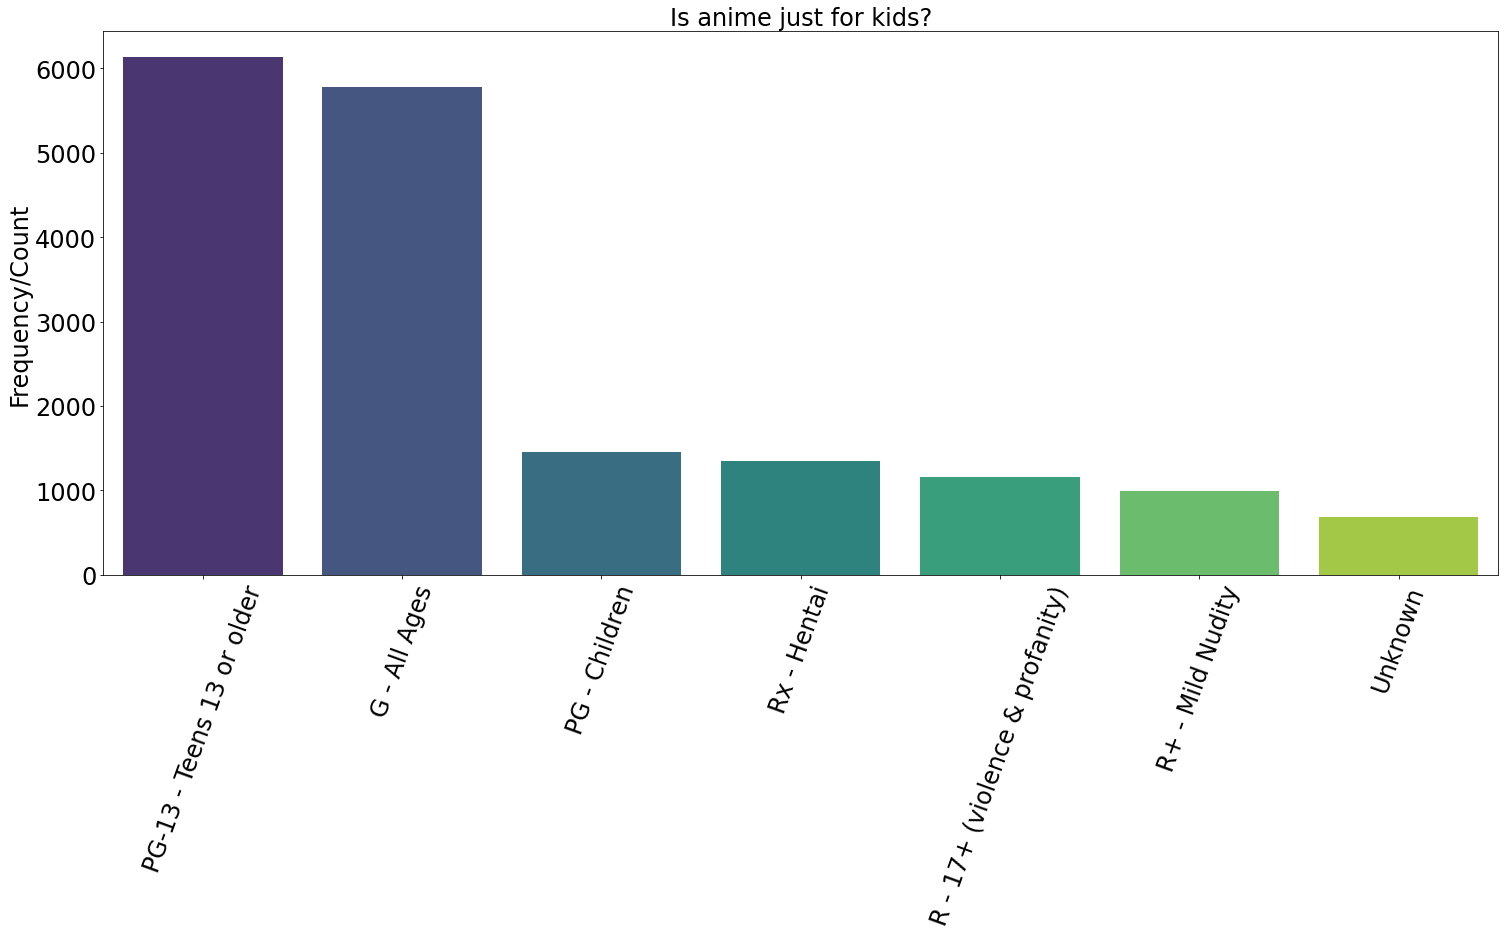

In [21]:
group_by_rating = anime.\
      groupby('Rating')\
      ['MAL_ID'].count().\
      sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.countplot(x="Rating",
                   data=anime,
                   order=group_by_rating.index,
                  palette='viridis')
plt.xlabel("Before 2013", fontsize=24)
plt.ylabel("Frequency/Count", fontsize=24)
plt.title("Is anime just for kids?", fontsize=24)
# ax.set_xticks([0,1])
ax.set_xticklabels(group_by_rating.index, rotation=70)
ax.set_xlabel(None)
ax.tick_params(labelsize=24)
plt.show()
plt.close()

## Anime production through the years
Based on the analysis so far performed it has been possible to establish that anime fans have a string preference to watch and appreciate more recently produced anime than those who came before the 2010s.\
It is therefore natural to consider how the anime prodcution scene has changed through the years, which means to look at the number of anime produced through the years to see how the increase interest of the fans for the product has influenced the industry.\
In the following 3 plots the fcount pf anime produced every year, the count of anime produced very seasons in the past 10 years and the count of source are shown. 

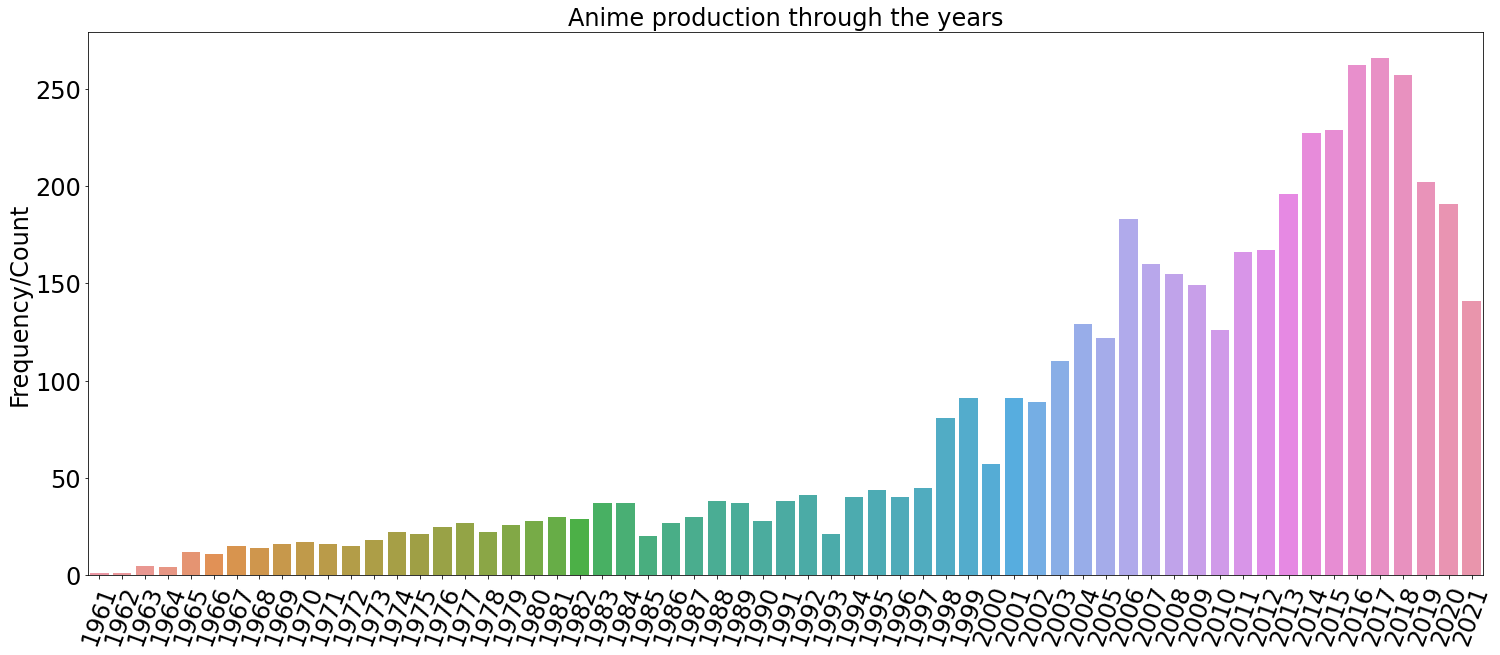

ModeResult(mode=array([2017]), count=array([266]))


In [22]:
# print(anime.columns)
anime_year = anime[anime['Year'] > 1868]
fig, ax = plt.subplots(figsize=(25,10))
sns.countplot(data=anime_year,
             x='Year')
plt.ylabel("Frequency/Count", fontsize=24)
plt.title("Anime production through the years", fontsize=24)
# ax.set_xticks([0,1])
ax.set_xticklabels(range(1961, 2022), rotation=70)
ax.set_xlabel(None)
ax.tick_params(labelsize=24)
plt.show()
plt.close()
print(stats.mode(anime_year['Year']))

The plot above clearly shows how anime has had a gradual but steady increase from its early years at the beginning of the 1960s and how there is been a dramatic increase in number from the early 2000s.\
This increase was probaby helped by the spread of internet use and discussion on forums and blog posts with anime being made more widely available also thanks to fansub groups.
Another change in the trend can be noticed at the beginning of the years 2010s. Here the anime streaming era began and the anime production increased of around **30%** more with respect of the previous years.\
Between the years 2015 and 2017 the peak of anime prduction was reached with 250+ anime produced per year, with a staggering **266**  new prodcutions only in the year 2017, the most prolific year for anime so far.\
Anime industry has prodcution has changed a lot through the years:The total number of anime prduced each year  from **1961** to the late **1990s** is often lower than the anime produced in the span of a single season in the years **2010s** as it is shown in the following plot.\
From the plot it also appears that spring is the on average the season where most of the anime is released.

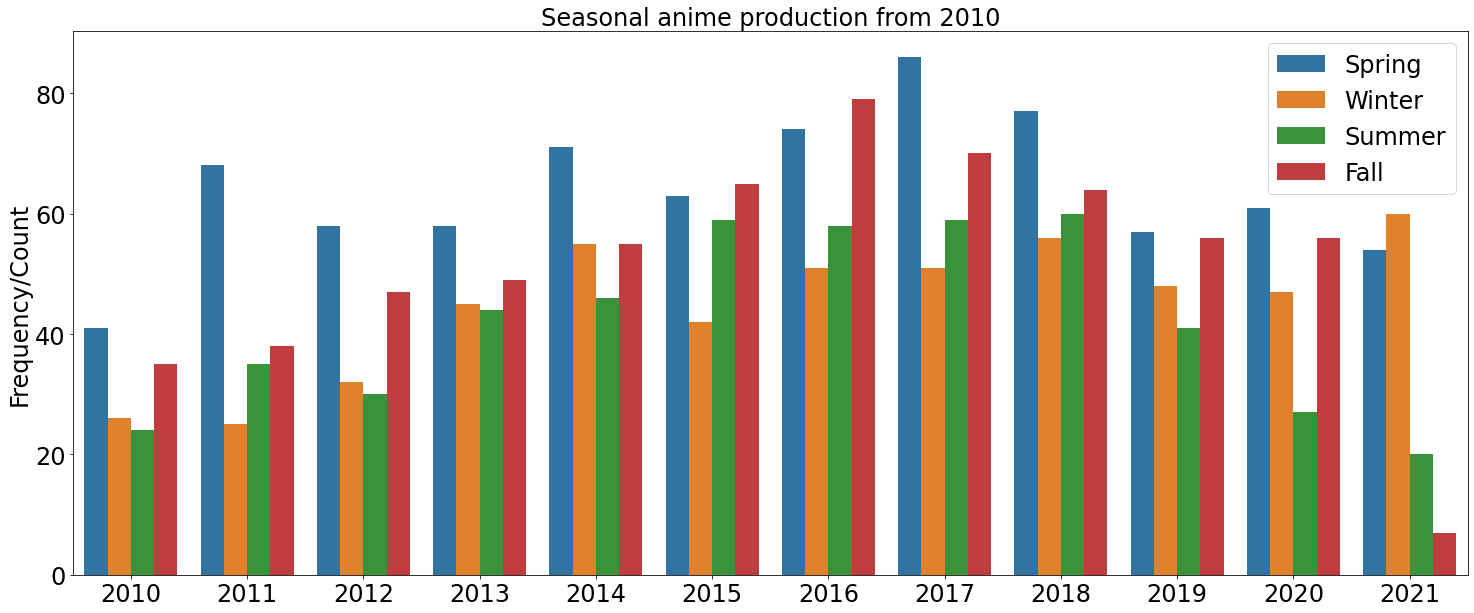

3        2002
16       2003
29       2002
37       2003
50       2005
         ... 
17483    2021
17500    2021
17535    2021
17553    2021
17554    2021
Name: Year, Length: 929, dtype: int64


In [23]:
anime_from_2010 = anime[anime['Year'] >= 2010]
fig, ax = plt.subplots(figsize=(25,10))
sns.countplot(data=anime_from_2010,
             x='Year',
             hue='Season')
plt.ylabel("Frequency/Count", fontsize=24)
plt.title("Seasonal anime production from 2010", fontsize=24)
plt.legend(fontsize=24)
# ax.set_xticks([0,1])
# ax.set_xticklabels(, rotation=70)
ax.set_xlabel(None)
ax.tick_params(labelsize=24)
plt.show()
plt.close()
print(anime['Year'][(anime['Source']== 'Original') & (anime['Year'] > 1999)])


### Original anime production
The increased availability of anime together with positive response of new anime fans has pushed creators to produced more and more anime to satisfy the requests of the fans.\
Anime orginal production are 

['Original' 'Manga' 'Light novel' 'Game' 'Visual novel' '4-koma manga'
 'Novel' 'Unknown' 'Other' 'Picture book' 'Web manga' 'Music' 'Radio'
 'Book' 'Card game' 'Digital manga']


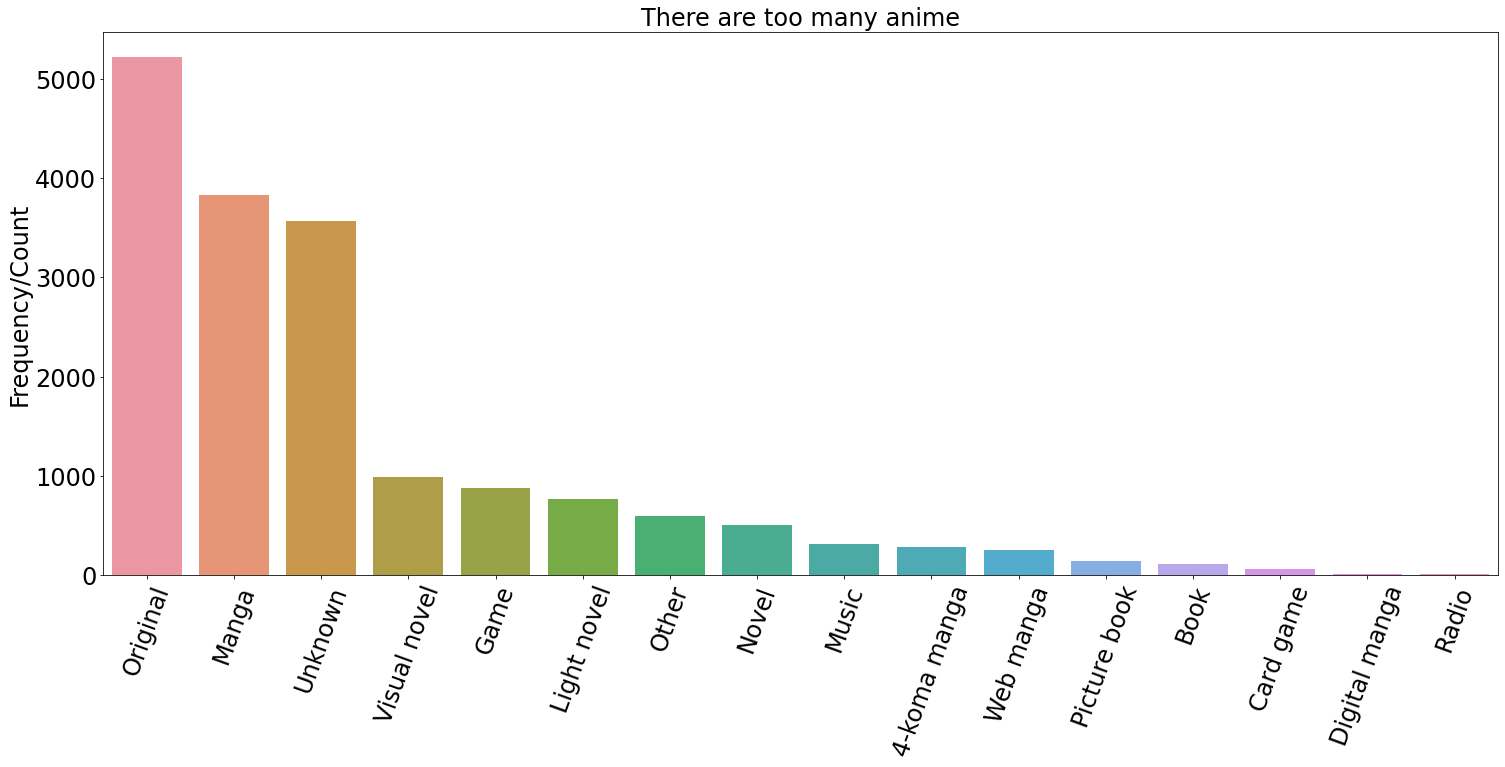

In [24]:

# Anime original are a lot
print(anime['Source'].unique())
group_by_source = anime.\
      groupby('Source')\
      ['MAL_ID'].count().\
      sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(25,10))
sns.countplot(data=anime,
             x='Source',
             order=group_by_source.index)
plt.xlabel("Before 2013", fontsize=24)
plt.ylabel("Frequency/Count", fontsize=24)
plt.title("There are too many anime", fontsize=24)
ax.set_xlabel(None)
ax.tick_params(labelsize=24)
ax.set_xticklabels(group_by_source.index, rotation=70)
plt.show()
plt.close()

## Gender gap in anime
Anime is very popular among young teenage boys.
Shows such as [**Dragon Ball Z**](https://myanimelist.net/anime/813/Dragon_Ball_Z), [**One Piece**](https://myanimelist.net/anime/21/One_Piece) and more recently [**My Hero Academia**](https://myanimelist.net/anime/31964/Boku_no_Hero_Academia) are specifically intended for that demographic. The genre that identifyies this kind of product is known as `Shounen`.
But how much is anime popular among girls? How many `Shoujo` shows (the female equivalent of Shounen) like [**Sailor Moon**](https://myanimelist.net/anime/530/Bishoujo_Senshi_Sailor_Moon), [**Nana**](https://myanimelist.net/anime/877/Nana) and [**Card captor Sakura**](https://myanimelist.net/anime/232/Cardcaptor_Sakura) are produced?
The comaprison is presented in the following two plots where the aggregate of male vs famale intended shows are shown. Also anime belonging to the genre of `Seinen` and `Josei` i.e. the equaivalent as Shounen and Shoujo but for older audience are reported in the graphs.
The comparison of the aggregated genres is shown in the following two graphs where anime for male.
About 80% of all the anime produced is intended for male audience.


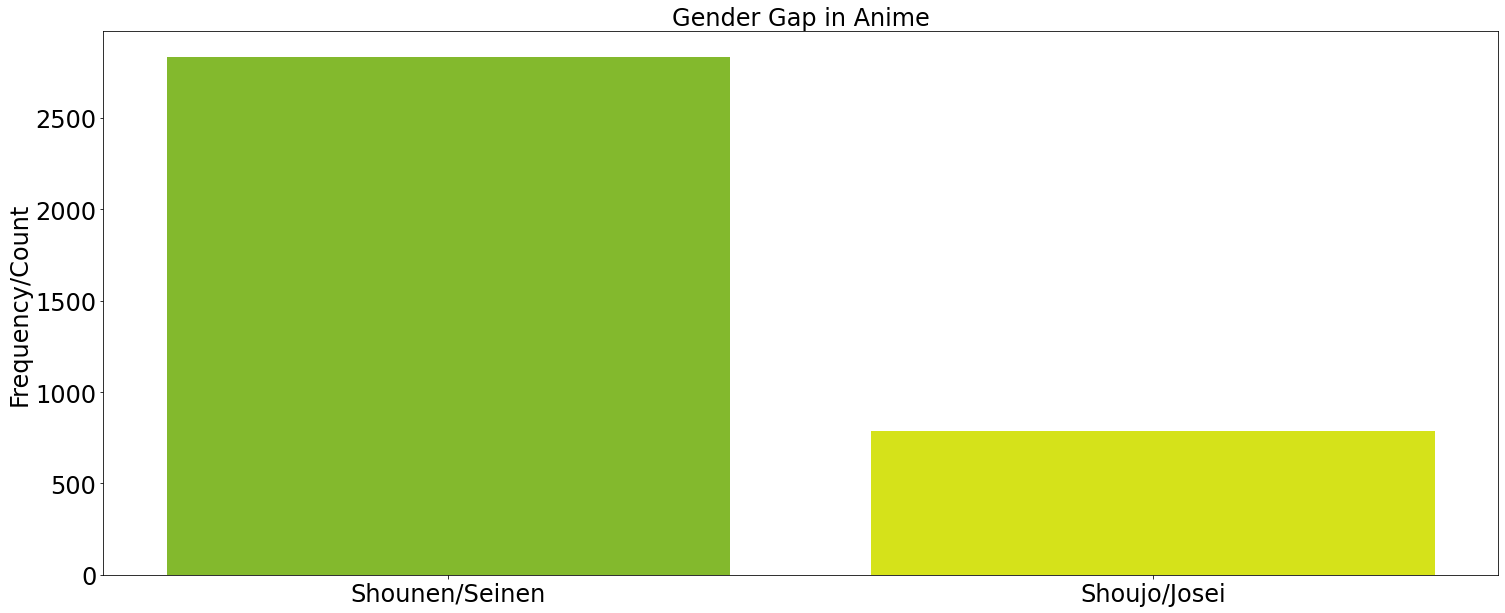

In [25]:
genres = []
for i in range(len(anime)):
    genre_list = anime['Genres'].iloc[i].split(',')
    for j in genre_list:
        genres.append(j.strip())
genres = pd.Series(data=genres)

male = genres[(genres == 'Shounen') | (genres == 'Seinen')].count()
female = genres[(genres == 'Shoujo') | (genres == 'Josei')].count()
gender = [male, female]

fig, ax = plt.subplots(figsize=(25, 10))
plt.bar(range(len(gender)), gender,
       color=['#83b92d', '#d5e21a'])
ax.set_xticks(range(len(gender)))
ax.set_xticklabels(['Shounen/Seinen', 'Shoujo/Josei'])
ax.tick_params(labelsize=24)
plt.ylabel('Frequency/Count', fontsize=24)
plt.title('Gender Gap in Anime', fontsize=24)

plt.show()
plt.close()


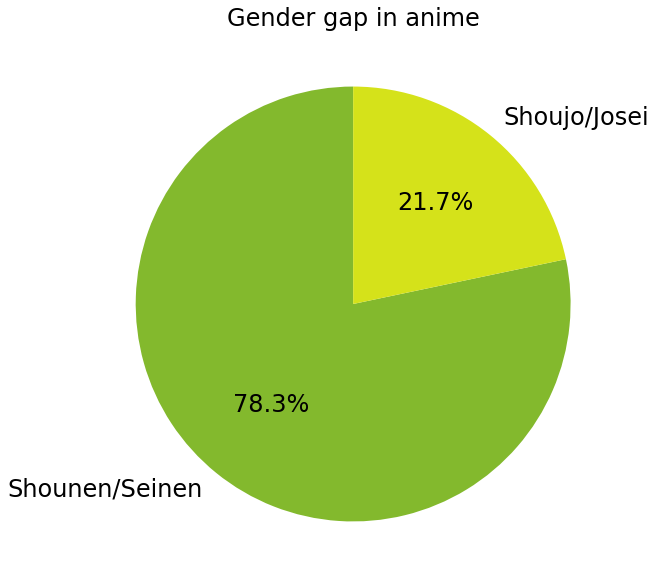

In [26]:
ax, fig = plt.subplots(figsize=(10,10))
patches, texts, autotexts = fig.pie(gender,
       autopct='%1.1f%%',
       startangle=90,
       labels =['Shounen/Seinen', 'Shoujo/Josei'],
       colors=['#83b92d', '#d5e21a'])
texts[0].set_fontsize(24)
texts[1].set_fontsize(24)
autotexts[0].set_fontsize(24)
autotexts[1].set_fontsize(24)

plt.title("Gender gap in anime", fontsize=24)
plt.show()

### Anime Studios
Great anime are often associated to great production studios.\


['Bones' 'Madhouse' 'Toei Animation' 'Kyoto Animation' 'Studio Pierrot'
 'Gainax' 'ufotable' 'White Fox' 'MAPPA' 'Wit Studio' 'Trigger']


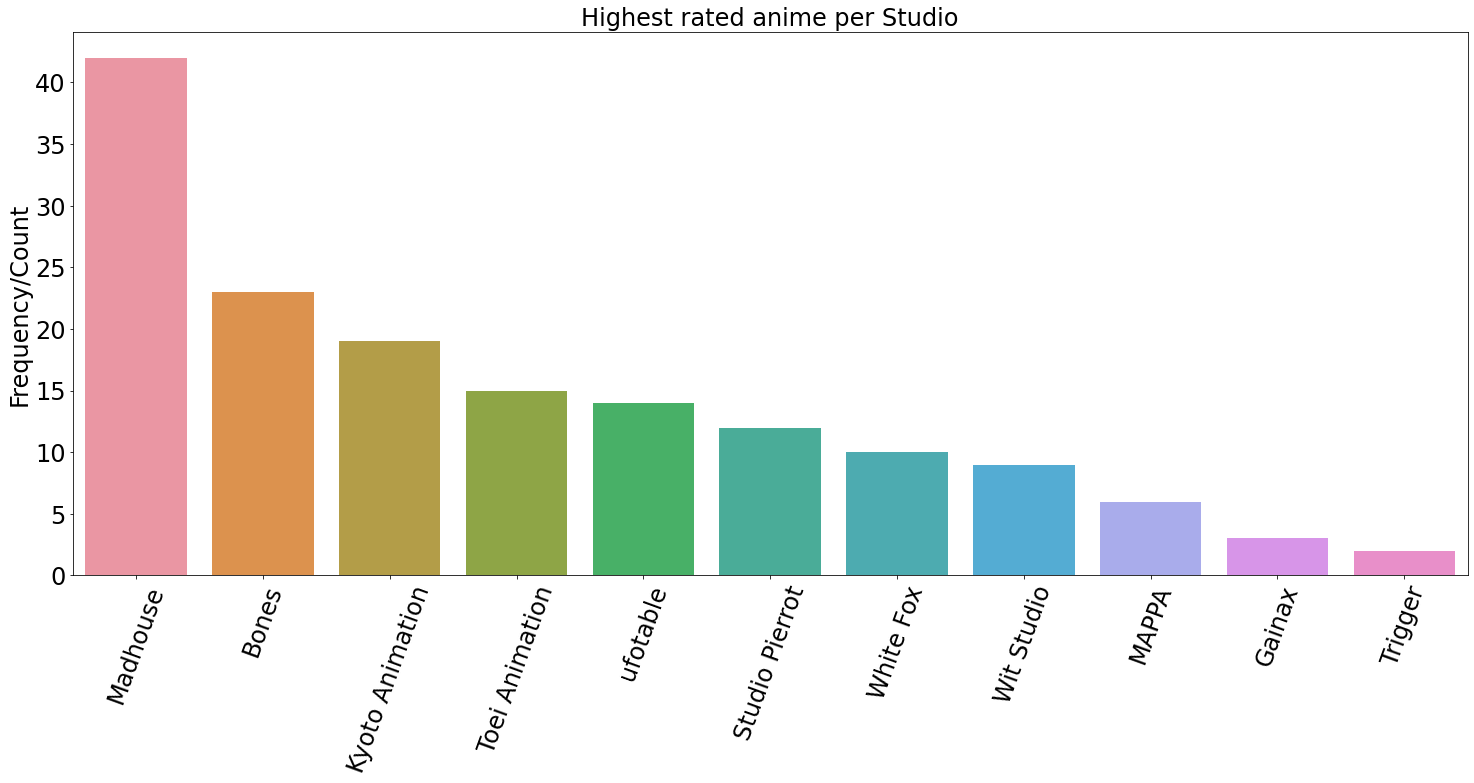

In [27]:
anime_studio = anime[(anime['Score'] > 8) &\
                     (anime['Studios'].isin(['Madhouse',
                                            'White Fox',
                                            'Bones',
                                            'MAPPA',
                                            'ufotable', 
                                            'Trigger',
                                            'Gainax',
                                            'Toei Animation',
                                            'Kyoto Animation',
                                            'Wit Studio',
                                            'Studio Pierrot']))]

print(anime_studio['Studios'].unique())
group_by_studios = anime_studio.\
      groupby('Studios')\
      ['MAL_ID'].count().\
      sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(25, 10))
sns.countplot(data=anime_studio,
             x='Studios',
             order=group_by_studios.index)
plt.ylabel('Frequency/Count', fontsize=24)
# ax.set_xticks([0,1])
ax.set_xlabel(None)
ax.tick_params(labelsize=24)
ax.set_xticklabels(group_by_studios.index, rotation=70)

plt.title('Highest rated anime per Studio', fontsize=24)
plt.show()
plt.close()
# print(anime_studio['Name'][(anime_studio['Studios'] == 'Madhouse') & (anime_studio['Score'] > 8)])
# print((group_by_studios.values))

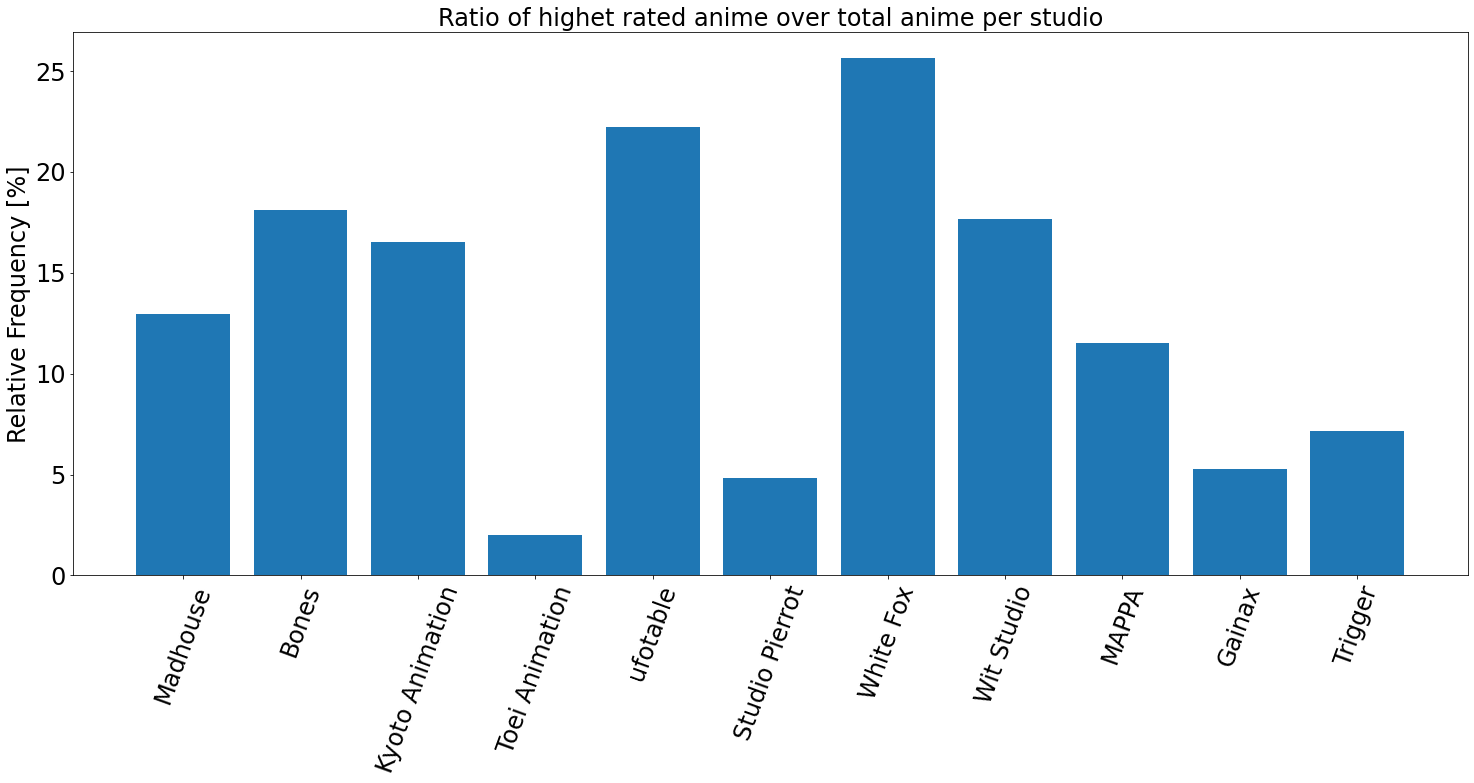

In [28]:
ratio = []
for studio, count in zip(group_by_studios.index, group_by_studios.values):
    ratio.append(count / len(anime[anime['Studios'] == studio]) * 100)
# Percentage of great anime over total anime made at studios
fig, ax = plt.subplots(figsize=(25, 10))
plt.bar(range(0,len(ratio)),ratio)
plt.ylabel('Relative Frequency [%]', fontsize=24)
# plt.xlabel('Studios', fontsize=24)
plt.title('Ratio of highet rated anime over total anime per studio', fontsize=24)
ax.tick_params(labelsize=24)
ax.set_xticks(range(0,len(ratio)))
ax.set_xticklabels(group_by_studios.index, rotation=70)
plt.show()

# CORRELATION

Are original anime better the manga or light novel adaptation? In Other words is there correlation between the score anime score and the source material?
Let's find out
What would be also nice to test would be the score of the manga and the score of the anime. But the manga dataset is not available now.
Instead what we are trying to find the correlation between a categorical variable (the source material) and a numerical variable (the score). Not sure how to do this.
Thus we seek to find correlation between two categorical variables whetere the anime is great i.e. score > 8 and the source is either manga or novel or original.
Another interesting correlation to explore would be year and popularity. This time it wil lbe between two numerical variable

In [29]:
# Manga or novel
anime_manga_original = anime[ (anime['Source'] == 'Manga') |\
                             (anime['Source'] == 'Original') |\
                             (anime['Source'] == 'Light novel')]

anime_manga_original['Manga/Novel'] =  anime_manga_original['Source'].apply(lambda source: \
                                                                            False if source == 'Original'\
                                                                           else True)
anime_manga_original['Is Great'] =  anime_manga_original['Score'].apply(lambda score: \
                                                                            True if score > 8\
                                                                           else False)

/home/andrea/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [30]:
source_score = pd.crosstab(anime_manga_original['Manga/Novel'], anime_manga_original['Is Great'])
source_score_frequency = source_score / len(anime_manga_original)
# source_marginal_frequency = source_score_frequency.sum(axis=0)
# score_marginal_frequency = source_score_frequency.sum(axis=1)
chi2, pval, dof, expected = stats.chi2_contingency(source_score_frequency)
print(source_score_frequency)
print(chi2)

Is Great        False      True
Manga/Novel                    
False        0.523960  0.007749
True         0.431485  0.036807
22.1054284273304


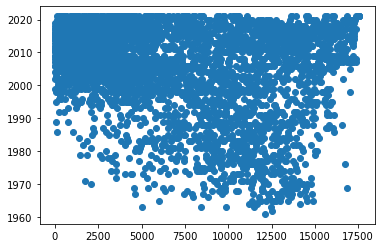

[[ 2.46188855e+07 -2.21503788e+04]
 [-2.21503788e+04  1.66365804e+02]]
-0.3461106257983587


In [31]:
plt.scatter(x = anime['Popularity'][anime['Year'] > 1880], y = anime['Year'][anime['Year'] > 1880])
plt.show()

cov_mat_popularity_year = np.cov(anime['Popularity'][anime['Year'] > 1880], anime['Year'][anime['Year'] > 1880])
corr_popularity_year, p = stats.pearsonr(anime['Popularity'][anime['Year'] > 1880], anime['Year'][anime['Year'] > 1880])

print(cov_mat_popularity_year)
print(corr_popularity_year)

There is a large negative correlation which means that shows from recent years are indeed the most popular ones. Keep in mind that popularity is highest when the associated value is low.

## Correlation between score and number of episodes


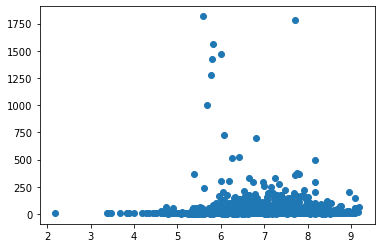

2266                           Doraemon (1979)
4536        Manga Nippon Mukashibanashi (1976)
5282                          Hoka Hoka Kazoku
5991                                   Lan Mao
6124                     Sekai Monoshiri Ryoko
6742                                Oyako Club
8629     Monoshiri Daigaku: Ashita no Calendar
8910                    Kirin Monoshiri Yakata
11375                 Kirin Ashita no Calendar
Name: Name, dtype: object
[[ 6.23385365e-01 -8.19026742e-01]
 [-8.19026742e-01  5.29661069e+03]]
-0.014253474878797844


In [32]:
plt.scatter(x = tv['Score'][tv['Score'] > 0], y = tv['Episodes'][tv['Score'] > 0])
plt.show()
print(anime["Name"][anime['Episodes'] > 850])
cov_anime_episode = np.cov(tv['Score'][tv['Score'] > 0], tv['Episodes'][tv['Score'] > 0])
print(cov_anime_episode)
corr_score_episode, p = stats.pearsonr(tv['Score'][tv['Score'] > 0], tv['Episodes'][tv['Score'] > 0])
print(corr_score_episode)